In [1]:
import os
import pickle
import numpy as np
import xgboost as xgb
import pandas as pd

n_bootstrap = 1

ft_dir = 'features_long/'

files = os.listdir(ft_dir)

with open('top_locations.dat') as f:
    state_top10 = pickle.load(f)
f.close()
for (i,s) in enumerate(state_top10):
    state_top10[i] = state_top10[i].replace('"','')
    state_top10[i] = state_top10[i].replace('[','')
    state_top10[i] = state_top10[i].replace(']','')

feature_all = []
state_all = []
state_fsq_all = []
for filename in files:
    with open(ft_dir+filename) as f:  
        feature, state = pickle.load(f)
        
        # only keeping top 10 states
        ind = np.array([], int)
        for (i,st) in enumerate(state['location']):
            if st in state_top10:
                ind = np.append(ind, i)
        feature = feature.loc[ind,:]
        state = state.loc[ind,'location']
        
        feature = feature.reset_index(drop = True)
        state = state.reset_index(drop = True)
        
        feature_all.append(feature)
        state_all.append(state)
        
    f.close()

inds = np.arange(0,len(feature_all),1)
inds_split = np.floor(0.7*len(feature_all))
    
gbm = [[] for _ in range(n_bootstrap)]
for sd in range(n_bootstrap):
    print sd,

    # method 1: random sampling
    np.random.shuffle(inds)
    ind_train = inds[:inds_split]
    x_train = pd.concat([feature_all[j] for j in ind_train], axis=0)
    y_train = pd.concat([state_all[j] for j in ind_train], axis=0)

    # method 2: one sample per subject
#     x_train = pd.DataFrame(columns=feature_all[0].columns)
#     y_train = pd.Series(name=state_all[0].name)
#     for i in range(len(feature_all)):
#         ind = np.random.choice(np.arange(feature_all[i].shape[0]),size=1)
#         x_train = pd.concat([x_train, feature_all[i].loc[ind,:]], axis=0)
#         y_train = pd.concat([y_train, state_all[i].loc[ind]], axis=0)
#         x_train = x_train.reset_index(drop = True)
#         y_train = y_train.reset_index(drop = True)
    
    # method 3: one class sampled from each subject
#     x_train = pd.DataFrame(columns=feature_all[0].columns)
#     y_train = pd.Series(name=state_all[0].name)
#     for i in range(len(feature_all)):
#         state_uniq = np.unique(state_all[i])
#         ind_uniq = np.random.choice(np.arange(state_uniq.size),size=1)[0]
#         ind = (state_all[i]==state_uniq[ind_uniq])
#         x_train = pd.concat([x_train, feature_all[i].loc[ind,:]], axis=0)
#         y_train = pd.concat([y_train, state_all[i].loc[ind]], axis=0)
#         x_train = x_train.reset_index(drop = True)
#         y_train = y_train.reset_index(drop = True)

    gbm[sd] = xgb.XGBClassifier(max_depth=6, n_estimators=75, learning_rate=0.05, nthread=12, subsample=0.25, \
                        colsample_bytree=0.2, max_delta_step=0, gamma=3, objective='mlogloss', reg_alpha=0.5, \
                        missing=np.nan).fit(np.array(x_train), np.array(y_train))


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [17]:
# dumping to a file

gbm[0].booster().dump_model('trees.txt')

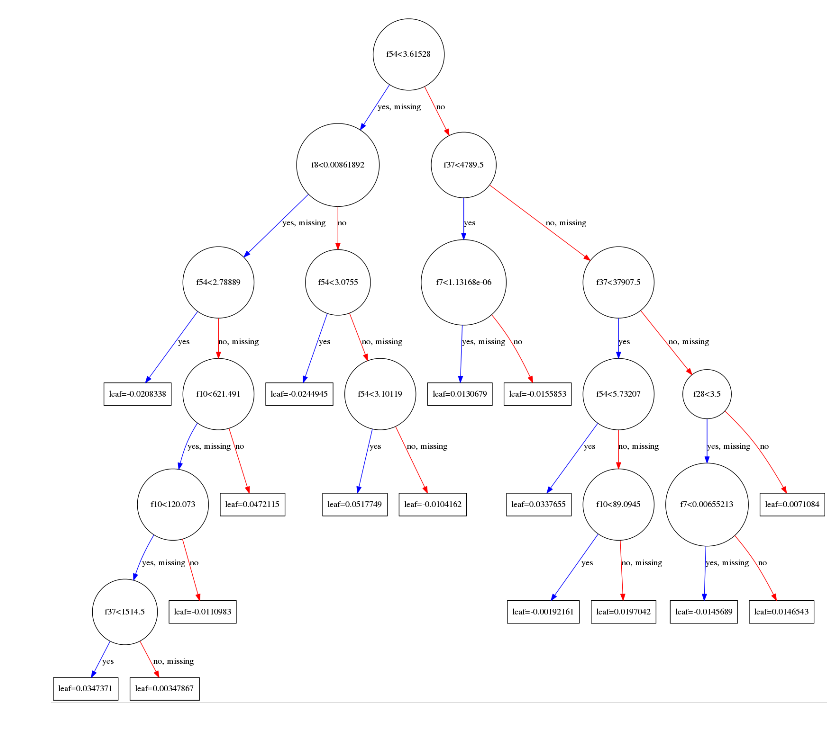

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=[10,10])
ax = fig.gca()
gb = gbm[0]
xgb.plot_tree(gb, num_trees=824, ax=ax)

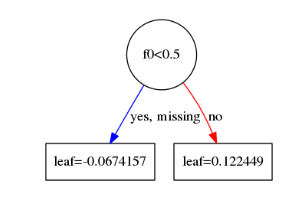

In [68]:
# testing

x = np.concatenate([np.ones([10,1])*np.array([1,0,0]),np.ones([10,1])*np.array([0,1,0]),np.ones([10,1])*np.array([0,0,1])], axis=0)
# y = np.concatenate([np.ones([10,1]), 2*np.ones([10,1]), 3*np.ones([10,1])], axis=0)
y = np.array([['a']*10+['c']*10+['b']*10]).reshape([30,1])

model = xgb.XGBClassifier(n_estimators=2, objective='mlogloss').fit(x, y)
model.booster().dump_model('trees.txt')

fig = plt.figure(figsize=[3,3])
ax = fig.gca()
xgb.plot_tree(model, num_trees=0, ax=ax)

In [69]:
np.unique(y)

array(['a', 'b', 'c'], 
      dtype='|S1')